In [2]:
import numpy as np
import healpy as hp
from astropy.io import fits
import h5py
from astropy.table import Table

In [17]:
from scipy import interpolate
def dist_mod(z_vals,d='/global/homes/w/wballard/standard-sirens/'):
   z = np.load(d+'dist_mod_kcorr.npz')['z']
   dm = np.load(d+'dist_mod_kcorr.npz')['dm']
   f_dm = interpolate.interp1d(z, dm, kind='cubic', bounds_error=False, fill_value=0)
   return f_dm(z_vals)

In [18]:
ra_column_name='TARGET_RA'
dec_column_name='TARGET_DEC'
z_column_name='Z'
zerr_column_name='ZERR'
flux_column_name='FLUX_R'
pix_column_name='hpix1024'
ebv_column_name='EBV'
target_column_name='TARGETID'
glx_catalog_name="/global/homes/w/wballard/standard-sirens/reducedCatalogBGS.fits"

h=fits.open(glx_catalog_name,memmap=True)[1].data
flux_g=h[flux_column_name]
z_g=h[z_column_name]
ra_g=h[ra_column_name]
dec_g=h[dec_column_name]
zerr_g=h[zerr_column_name]
pix_g=h[pix_column_name]
ebv_g=h[ebv_column_name]
extinction_coeff=2.165

transmission_mw=ebv_g*extinction_coeff
corrected_flux=flux_g/transmission_mw
omag_g=22.5-2.5*np.log10(corrected_flux) #from legacy survey webpage
abs_mag=omag_g-dist_mod(z_g)
abs_mag_cut=abs_mag<-21.5
flux=flux_g[abs_mag_cut]
z=z_g[abs_mag_cut]
ra=ra_g[abs_mag_cut]
dec=dec_g[abs_mag_cut]
zerr=zerr_g[abs_mag_cut]
pix=pix_g[abs_mag_cut]
print(len(pix))

outlabel="goodCatalog.fits"
t=Table([ra,dec,z,zerr,pix],
        names=('TARGET_RA','TARGET_DEC','Z','ZERR', 'hpix1024'))
t.write(outlabel,format='fits',overwrite=True)

5479226


[6255258 6230686 6222495 ... 3016700 3082243 3061756]


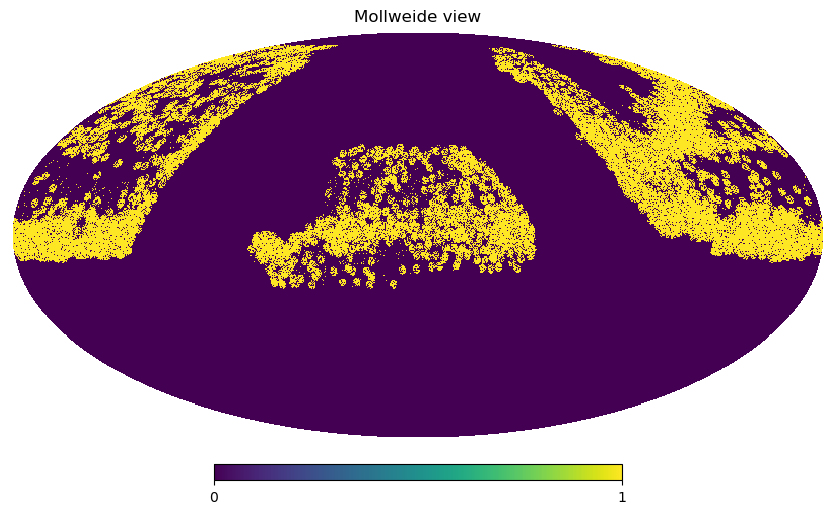

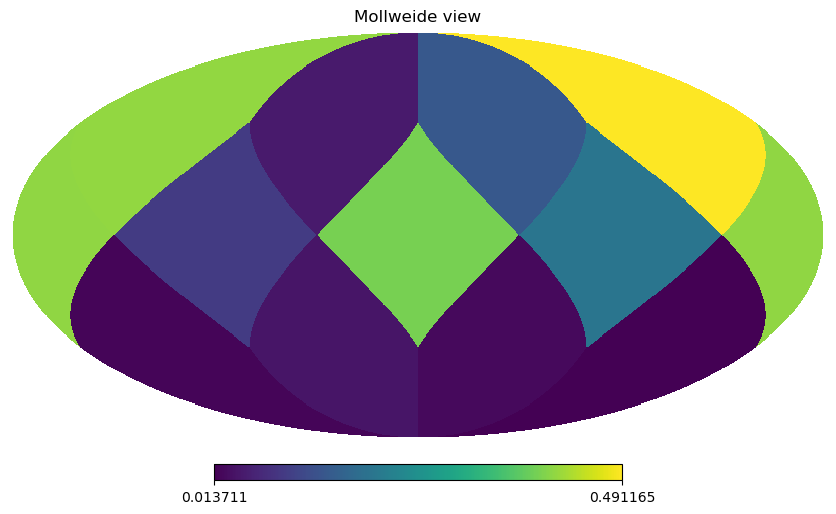

In [3]:
h=fits.open('goodCatalog.fits',memmap=True)[1].data
pix=h['hpix1024']
test=np.arange(hp.nside2npix(1024))
m = np.zeros(hp.nside2npix(1024))
m[pix]=1
hp.mollview(m)
m=hp.ud_grade(m,1)
hp.mollview(m)
hp.nside2pixarea(1024,degrees=True)
print(pix)

#def map_hi_to_low_res(hi_npix,low_npix,pixarr):
    
    

In [12]:
def compute_map_array(nside_high, nside_low,pix_arr):
    map_array=np.empty(len(pix_arr))
    i=0
    for pixel in pix_arr:
        hpidx_high = hp.pix2ang(nside_high, pixel)
        hpidx_low = hp.ang2pix(nside_low, hpidx_high[0], hpidx_high[1])
        #print(f"High-res Pixel {pixel} -> Low-res Pixel {hpidx_low}")
        map_array[i]=hpidx_low
        i+=1
    return map_array

[7. 7. 7. ... 4. 4. 4.]


In [7]:
print(np.unique(map_array))

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11.]


In [8]:
def write_skymap_frac(map_arr,pixel_num,ra,dec,z,zerr):
    mask=(map_arr==pixel_num)
    ra_t=ra[mask]
    dec_t=dec[mask]
    z_t=z[mask]
    zerr_t=z[mask]
    with h5py.File('/global/homes/w/wballard/standard-sirens/skymap'+str(pixel_num)+'FRAC.h5', 'w') as f:
        f.create_dataset('RA',data=ra_t,compression='gzip', shuffle=False)
        f.create_dataset('DEC',data=dec_t,compression='gzip', shuffle=False)
        f.create_dataset('Z',data=z_t,compression='gzip', shuffle=False)
        f.create_dataset('ZERR',data=ra_t,compression='gzip', shuffle=False)
        
    

In [15]:
ra=h['TARGET_RA']
dec=h['TARGET_DEC']
z=h['Z']
zerr=h['ZERR']
map_array=compute_map_array(1024,1,pix)
write_skymap_frac(map_array,11,ra,dec,z,zerr)